In [ ]:
from google.colab import files
import zipfile
import os

# Upload the ZIP file containing all material folders (glass, wood, metal, plastic)
uploaded = files.upload()

Saving project1_dataset.zip to project1_dataset (1).zip


In [ ]:
# Extract uploaded ZIP file
zip_path = "/content/project1_dataset.zip" # Extract zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("materials_dataset") #This line of code will extract to a new folder

In [ ]:
import numpy as np
from PIL import Image # Importing the image class specifically
import os

data_dir = "materials_dataset"  # Path to extracted dataset
img_size = (128, 128)  # This is to resize for efficiency

x = [] # Initialize x as a list
y = [] # Initialize y as a list

In [ ]:
# Sorted list of the class folder
labels = sorted(os.listdir("materials_dataset/project1_dataset"))
print("Class labels found:", labels)

Class labels found: ['glass', 'metal', 'plastic', 'wood']


In [ ]:
import numpy as np
from PIL import Image # Importing the image class specifically
import os

data_dir = "materials_dataset/project1_dataset"  # Path to extracted dataset
img_size = (128, 128)  # This is to resize for efficiency

x = [] # Initialize x as a list
y = [] # Initialize y as a list

# Loop through folders and images
for label_index, label_name in enumerate(labels): # loop for each label and the index
    folder_path = os.path.join(data_dir, label_name) #Getting the full path for the current label
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')): #Checking to see if the file matches the file extensions listed
            img_path = os.path.join(folder_path, filename) # Full path to the image file
            try:
                img = Image.open(img_path).convert('RGB').resize(img_size) # Converting the RGB and resize
                x.append(np.array(img).flatten()) #Convert to Numpy array and flatten to 1D
                y.append(label_index) #Store label index as a number for the image
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

# Convert lists to numpy arrays
X = np.array(x)
y = np.array(y)
print("Image dataset shape:", X.shape)

Image dataset shape: (400, 49152)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Normalize the pixel data
scaler = StandardScaler() # Reduces the number of pixels
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce features while preserving variance
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_scaled)

print("Original data shape:", X.shape)
print("After scaling:", X_scaled.shape)
print("After PCA (reduced features):", X_pca.shape)


Original data shape: (400, 49152)
After scaling: (400, 49152)
After PCA (reduced features): (400, 100)


In [ ]:
from sklearn.model_selection import train_test_split

#This code is splitting the dataset into training and testing sets
#test_size 20% of the data is used for training, the remaining is for training
#random_state makes for the split is the same for each run

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42)

# Print the shapes of the split datasets
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)


Training features shape: (320, 100)
Testing features shape: (80, 100)
Training labels shape: (320,)
Testing labels shape: (80,)


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth=10, random_state=42) #prevents overfitting/makes results reproducible
dt_model.fit(X_train, y_train)

print("Decision Tree model has been trained.")


Decision Tree model has been trained.


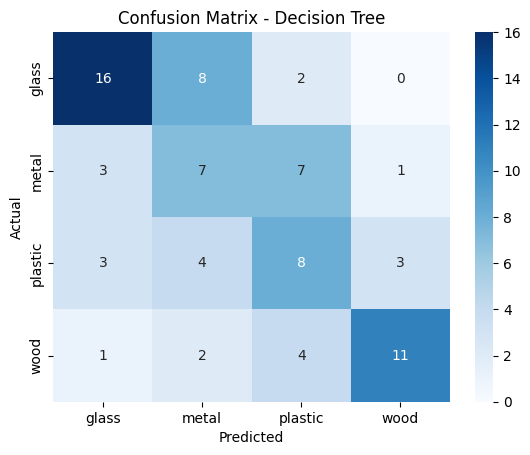

              precision    recall  f1-score   support

       glass       0.70      0.62      0.65        26
       metal       0.33      0.39      0.36        18
     plastic       0.38      0.44      0.41        18
        wood       0.73      0.61      0.67        18

    accuracy                           0.53        80
   macro avg       0.54      0.51      0.52        80
weighted avg       0.55      0.53      0.54        80



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns #Makes plots look clearner and adds color
import matplotlib.pyplot as plt

# Predict on test data
y_pred = dt_model.predict(X_test)

# Confusion matrix to show number of time model predicted correctly or incorrectly
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues" # map goes from light blue to dark blue( the darker the higher the prediction)
, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# Print detailed report
print(classification_report(y_test, y_pred, target_names=labels))


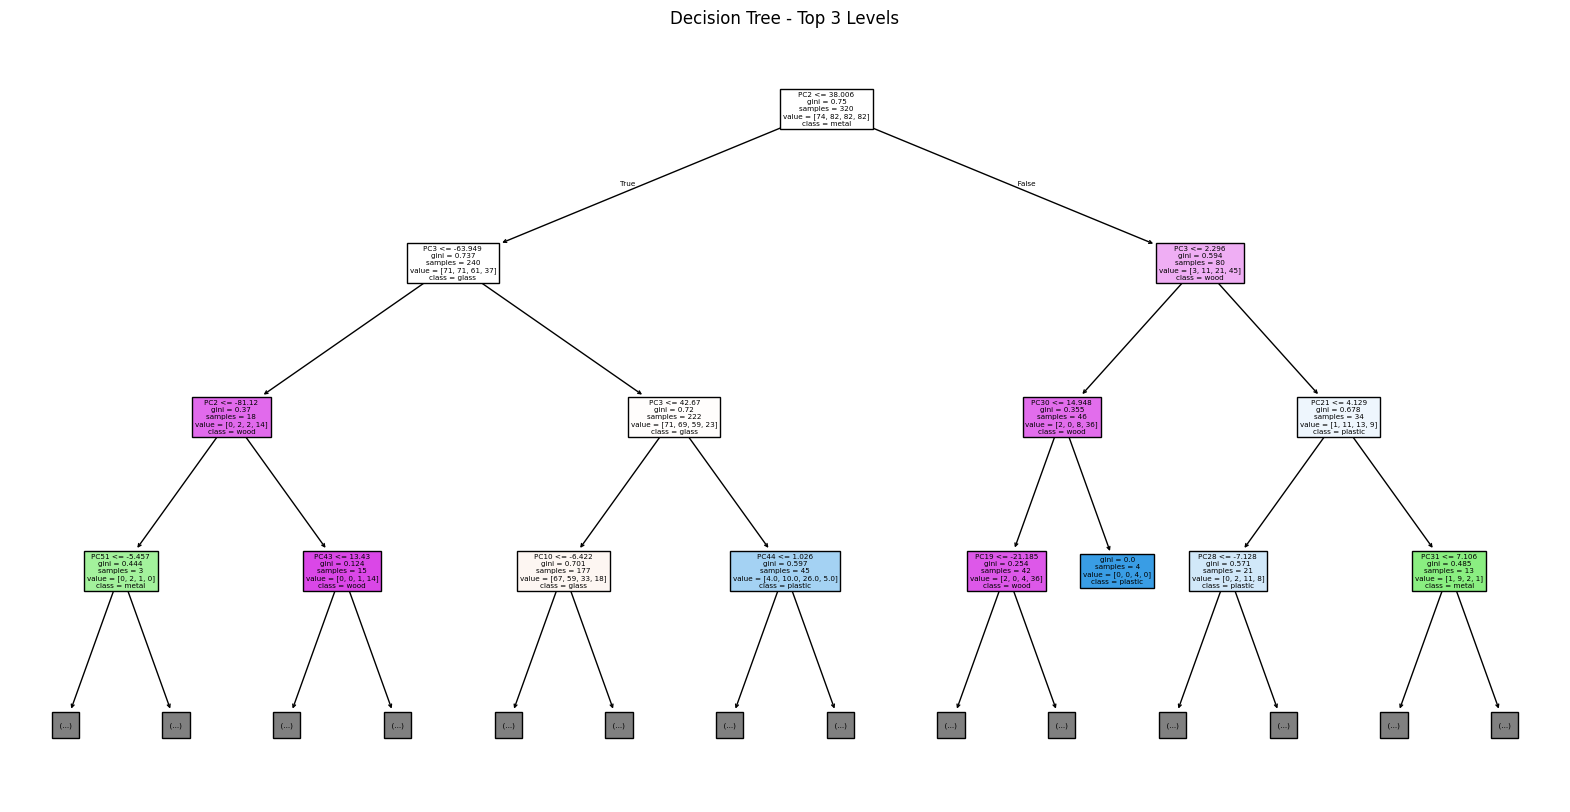

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))

#Only showing top three to keep it readable, and boxes colored to show the class strength
plot_tree(dt_model, max_depth=3, filled=True, class_names=labels,
          feature_names=[f'PC{i+1}' for i in range(X_pca.shape[1])]) # Each PCA is named

plt.title("Decision Tree - Top 3 Levels")
plt.show()

#Samples= how many images reach that point in the tree
#Value= how many samples per class in the node
#Class= predicted label for the node


In [ ]:
# Get top N important PCA components
importances = dt_model.feature_importances_
top_n = 10
top_indices = np.argsort(importances)[-top_n:]

print("Top PCA components and their importance:")
for idx in reversed(top_indices):
    print(f"PC{idx+1} — Importance: {importances[idx]:.4f}")


Top PCA components and their importance:
PC3 — Importance: 0.1244
PC2 — Importance: 0.0861
PC15 — Importance: 0.0647
PC19 — Importance: 0.0568
PC1 — Importance: 0.0482
PC43 — Importance: 0.0451
PC10 — Importance: 0.0380
PC82 — Importance: 0.0362
PC29 — Importance: 0.0299
PC30 — Importance: 0.0258


In [ ]:
from collections import defaultdict
from sklearn.tree import _tree

# Build a map from feature to class predictions at the leaves
feature_class_map = defaultdict(list)

# Get access to the raw tree object
tree = dt_model.tree_

# Recursive function to walk the tree
def walk_tree(node_id, class_prediction):
    # If leaf node, return
    if tree.children_left[node_id] == _tree.TREE_LEAF:
        return

    # Get split feature
    feature = tree.feature[node_id]

    # Get child nodes
    left_child = tree.children_left[node_id]
    right_child = tree.children_right[node_id]

    # Record which class this split leads to (most common at children)
    left_class = np.argmax(tree.value[left_child])
    right_class = np.argmax(tree.value[right_child])

    feature_class_map[feature].append((left_class, right_class))

    # Continue walking
    walk_tree(left_child, left_class)
    walk_tree(right_child, right_class)

# Start at root
walk_tree(0, None)


In [ ]:
print("\nTop PCA components and the classes they tend to separate:")

for idx in reversed(top_indices):
    class_pairs = feature_class_map.get(idx, [])
    class_freq = defaultdict(int)

    # Count how often this PCA feature leads to each class
    for left, right in class_pairs:
        class_freq[left] += 1
        class_freq[right] += 1

    # Sort by most common class
    sorted_classes = sorted(class_freq.items(), key=lambda x: -x[1])
    top_classes = [labels[c] for c, _ in sorted_classes[:2]]  # top 2 classes

    print(f"PC{idx+1} — Importance: {importances[idx]:.4f} — Most associated with: {', '.join(top_classes)}")



Top PCA components and the classes they tend to separate:
PC3 — Importance: 0.1244 — Most associated with: wood, glass
PC2 — Importance: 0.0861 — Most associated with: wood, glass
PC15 — Importance: 0.0647 — Most associated with: metal, glass
PC19 — Importance: 0.0568 — Most associated with: glass, metal
PC1 — Importance: 0.0482 — Most associated with: metal, plastic
PC43 — Importance: 0.0451 — Most associated with: plastic, metal
PC10 — Importance: 0.0380 — Most associated with: metal, glass
PC82 — Importance: 0.0362 — Most associated with: metal, plastic
PC29 — Importance: 0.0299 — Most associated with: glass, plastic
PC30 — Importance: 0.0258 — Most associated with: wood, plastic
